# Markowitz

To use in combination with AirBorne one first need to add Direct Search Manually and then AirBorne
```julia
add https://github.com/ImperialCollegeLondon/DirectSearch.jl
add "https://github.com/JuDO-dev/AirBorne.jl#dev"
add "https://github.com/JuDO-dev/AirBorne.jl#sma"
```

Once a module is added for the first time in order to refresh or switch the branch the command changes to:

```julia
add AirBorne#sma
```

# Julia Features Test

## Draft
The first step is to simply write the trading functions as a draft outside any module, test them and evaluate if the functions behave as expected. Since this is the first strategy for **production** metrics are also going to be put forward.

Therefore by the end of this Notebook code for several submodules is going to be developed

**Portfolio Calculations**

A question to solve is how the computation coming from the portfolio are stored? A simple answer would be inside the *extras* key of the **context** variable. Not all strategies may make use of portfolio calculations (like total value of portfolio), therefore an optional nature of its storage seems to be desirable.

**Metrics**
1. Returns: Given a series of stockprice calculate the returns
3. Variance & Covariance: Of Portfolio and individual assets.
2. Sharpe: 

### Utils.jl

In [68]:
using DataFrames: SubDataFrame,DataFrame
function get_latest_N(sdf::Union{SubDataFrame,DataFrame},by::Symbol,N::Int64; rev=false,fields::Vector=[])
    fields = fields==[] ? names(sdf) : fields
    sorted=sort(sdf,by;rev=rev)
    return DataFrame(Dict([x=>first(sorted[!,x],N) for x in fields]))
end

get_latest_N (generic function with 2 methods)

### NASDAQ.jl

In [15]:
# NASDAQ.jl
# ModulePath: Airborne.ETL.NASDAQ

using HTTP: HTTP
using JSON: JSON
using DataFrames: DataFrame
"""
    screener()

    Returns the data from  [NASDAQ's screner page](https://www.nasdaq.com/market-activity/stocks/screener).

    It provides a simple way also of getting a relatively large amount of US tickers.
"""
function screener()
    url="https://api.nasdaq.com/api/screener/stocks?tableonly=true&offset=0&download=true"
    r = HTTP.request("GET", url)
    body = deepcopy(r.text)
    resp_json = JSON.parse(String(body))
    out = DataFrame(resp_json["data"]["rows"])
    return out
end

screener (generic function with 1 method)

### Markowitz.jl

In [127]:
# SMA.jl
# ModulePath: Airborne.Strategies.Markowitz

# using ...Utils: sortedStructInsert!
# using ...Structures: ContextTypeA, TimeEvent
# using ...Markets.StaticMarket: Order, place_order!

using  AirBorne.Utils: sortedStructInsert!
using  AirBorne.Structures: ContextTypeA, TimeEvent
using  AirBorne.Markets.StaticMarket: Order, place_order!
using Dates: Day, year
using DataFrames: DataFrame, groupby, combine, mean
using DotMaps: DotMap
using DirectSearch: 
    DSProblem, Optimize!, SetInitialPoint, SetObjective, SetIterationLimit, SetGranularity, AddExtremeConstraint, AddProgressiveConstraint

"""

    The Markowitz strategy lies in obtaining a portfolio distribution that given past historical data
    the average return of each ticker is calculated with the covariance between the 

"""

function mwz_initialize!(context::ContextTypeA; horizon::Real=30, initialCapital::Real=10^5, min_growth::Real=0.001)
    
    ###################################
    ####  Parameters & Structures  ####
    ###################################
    context.extra.horizon = horizon
    
    context.extra.valueHistory=DataFrame()
    context.extra.returnHistory=DataFrame()
    context.extra.currentValue=DataFrame()
    context.extra.pastValue=DataFrame()
    
    context.extra.idealPortfolioDistribution =[]
    context.extra.min_growth=min_growth
    
    ###################################
    ####  Specify Account Balance  ####
    ###################################
    context.accounts.usd = DotMap(Dict())
    context.accounts.usd.balance = initialCapital
    context.accounts.usd.currency = "USD"
    
    #########################################
    ####  Define first simulation event  ####
    #########################################
    # Define First Event (Assumming the first event starts from the data
    # The first even should be at least as long as the long horizon)
    next_event_date = context.current_event.date
    new_event = TimeEvent(next_event_date, "data_transfer")
    sortedStructInsert!(context.eventList, new_event, :date)
    return nothing
end


function mwz_trading_logic!(context::ContextTypeA, data::DataFrame; tune_parameters::Dict=Dict())
    # 1. Specify next event (precalculations can be specified here) 
    next_event_date = context.current_event.date + Day(1)
    new_event = TimeEvent(next_event_date, "data_transfer")
    sortedStructInsert!(context.eventList, new_event, :date)
    
    # 2. Generate orders and  place orders
    # 2.1 Update data
    if size(data,1)==0 # No New data, nothing to do
        return nothing 
    end
    context.extra.pastValue=context.extra.currentValue
    context.extra.currentValue=stockValuation(data)
    [push!(context.extra.valueHistory,r) for r=eachrow(context.extra.currentValue)]
    
    if size(context.extra.pastValue,1)>0 # Add new data to history record
        r1 = returns(vcat(context.extra.pastValue,context.extra.currentValue))
        push!(context.extra.returnHistory,r1[end,:])
    end

    # 2.2 Calculate Statistics
    if size(context.extra.returnHistory,1)<context.extra.horizon
        return nothing # Not enough history data to 
    end
    
    d = context.extra.returnHistory[end-context.extra.horizon+1:end,:]
    M = covariance(d) # Covariance Matrix
    m = mean(Matrix(d[!,Not(["date","stockReturns"])]),dims=1)
    max_return,ix = findmax(m)
    if max_return>context.extra.min_growth # Feasible problem
    # 2.3 Solve Optimization problem
        if context.extra.idealPortfolioDistribution==[]
            initial_point = zeros(size(m))
            initial_point[ix]=1.0
        else
            initial_point = context.extra.idealPortfolioDistribution 
        end

        upper_cons(x) = all(x .<= 1) 
        lower_cons(x) = all(x .>= 0) 
        min_return(x) = context.extra.min_growth-(m*x)[1] # I want at least a 0.1% return in 1 day 
        obj(x) = x'*M*x 

        p = DSProblem(length(m))
        SetGranularity(p, Dict( [i => 0.001 for i=1:length(m)] ))
        SetObjective(p,obj)
        AddProgressiveConstraint(p, min_return)
        AddExtremeConstraint(p, upper_cons)
        AddExtremeConstraint(p, lower_cons)
        SetInitialPoint(p,vec([ i for i =initial_point]))
        Optimize!(p)
        context.extra.idealPortfolioDistribution = p.x
    else
        context.extra.idealPortfolioDistribution = zeros(size(m)) # Sell absolutely everytihng. Market is going down.
    end
    check=false
    if isnothing(context.extra.idealPortfolioDistribution) # Feasible solution not found!, sell all
        context.extra.idealPortfolioDistribution = zeros(size(m))
        check=true
    end
    
    # 2.4 Calculate shares to buy and sell to achieve optimal portfolio
    asset_names = names(context.extra.currentValue)[2:end-1]
    cv=reshape(Matrix(context.extra.currentValue)[2:end-1], (length(asset_names))) # Current value per share for ticker
    if length(context.portfolio)==0 # Obtain vector with current portfolio
        context.portfolio = Dict([name=>0.0 for name in names(context.extra.currentValue)][2:end-1])
    end
    currentPortfolio = reshape(Matrix(DataFrame(context.portfolio)), (length(asset_names)))
    total_capital = context.accounts.usd.balance + (currentPortfolio'*cv)[1] # Total capital to distribute 
    if check 
        @info "Check:" context.extra.idealPortfolioDistribution total_capital cv
        @info "Check:" size(context.extra.idealPortfolioDistribution)  size(total_capital) size(cv)
        
        @info context.extra.idealPortfolioDistribution.*total_capital
        @info [context.extra.idealPortfolioDistribution[i] * total_capital / cv[i] for i=1:length(cv)]
    end
    # nextPortfolio =  reshape(context.extra.idealPortfolioDistribution.*total_capital ./ cv, (length(asset_names))) # Amount of shares to have of each ticker
    nextPortfolio =  reshape([context.extra.idealPortfolioDistribution[i] * total_capital / cv[i] for i=1:length(cv)], (length(asset_names))) # Amount of shares to have of each ticker
    portfolioDiff=nextPortfolio-currentPortfolio
    
    # Summarize
    diffDf=DataFrame(Dict(["symbol"=>asset_names,"diff"=>portfolioDiff,"cv"=>cv]))
    diffDf[!,"total"]= diffDf.diff.*diffDf.cv
    diffDf=diffDf[diffDf.diff.!=0,:] # Keep only non-zero values
    sort!(diffDf[diffDf.diff.!=0,:],:total) # Sort such that largest sells happen first, and largest buy's later
    
    # 2.5 Produce and place orders
    for r=eachrow(diffDf)
            market,ticker= split(r.symbol,"/")
            order_specs = DotMap(Dict())
            order_specs.ticker = String(ticker)
            order_specs.shares = r.diff # Number of shares to buy/sell
            order_specs.type = "MarketOrder"
            order_specs.account = context.accounts.usd
            order = Order(String(market), order_specs)
            place_order!(context,order) 
    end
    return nothing
end


mwz_trading_logic! (generic function with 1 method)

## Test

### Add Data

# Using AirBorne

In [ ]:

from = DateTime("2017-01-01"); to = DateTime("2022-01-01")
u_from = string(round(Int, datetime2unix(from))); u_to = string(round(Int, datetime2unix(to)))
data = get_interday_data(["AAPL","GOOG"], u_from, u_to)


In [5]:
# If data needs to be generated
using AirBorne.ETL.YFinance: get_interday_data,get_chart_data
using AirBorne.ETL.Cache: load_bundle, store_bundle
using Dates: DateTime,datetime2unix
bundle_id="Mark1"
cache_dir = joinpath(@__DIR__, "assets", "cache")
# To generate this data use:
from = DateTime("2017-01-01"); to = DateTime("2022-01-01")
u_from = string(round(Int, datetime2unix(from))); u_to = string(round(Int, datetime2unix(to)))
# data = get_interday_data(["GC=F"], u_from, u_to)
r = get_chart_data("GC=F", u_from, u_to, "1d")

# For some reason  the column type is still "Any". Minor bug but annoying. 
# data[!,:close]=float.(data[!,:close])
# data[!,:high]=float.(data[!,:high])
# data[!,:low]=float.(data[!,:low])
# data[!,:open]=float.(data[!,:open])
# data[!,:unix]=Int.(data[!,:unix])
# data[!,:volume]=Int.(data[!,:volume])

# data[!,"assetID"] = data.exchangeName .* "/" .* data.symbol
# show(data)
# store_bundle(data; bundle_id=bundle_id, archive=true) 


HTTP.Messages.Response:
"""
HTTP/1.1 200 OK
content-type: application/json;charset=utf-8
vary: Origin,Accept-Encoding
cache-control: public, max-age=10, stale-while-revalidate=20
y-rid: 183ovn5ib0mu0
x-yahoo-request-id: 183ovn5ib0mu0
x-request-id: a2ec76e9-f83e-4404-8d76-d29d6672e3ad
content-encoding: gzip
x-envoy-upstream-service-time: 14
date: Thu, 13 Jul 2023 20:17:04 GMT
server: ATS
x-envoy-decorator-operation: finance-chart-api--mtls-baseline-production-ir2.finance-k8s.svc.yahoo.local:4080/*
Age: 0
Strict-Transport-Security: max-age=31536000
Referrer-Policy: no-referrer-when-downgrade
X-Frame-Options: SAMEORIGIN
Transfer-Encoding: chunked
Connection: keep-alive
Expect-CT: max-age=31536000, report-uri="http://csp.yahoo.com/beacon/csp?src=yahoocom-expect-ct-report-only"
X-XSS-Protection: 1; mode=block
X-Content-Type-Options: nosniff

{"chart":{"result":[{"meta":{"currency":"USD","symbol":"GC=F","exchangeName":"CMX","instrumentType":"FUTURE","firstTradeDate":967608000,"regularMarketT

In [22]:
# Float64.(tickers_df.ipoyear)
# Pre 2017 Symbols
using DataFrames: groupby, combine

########################################################
###    Pick the 5 most traded companies per sector   ###
########################################################
using AirBorne.ETL.NASDAQ: screener
using AirBorne.Utils: get_latest_N
tickers_df = screener()
filtered_df =tickers_df[[   x!="" ? parse(Int64, x)<2016 : false for x in tickers_df.ipoyear],["symbol","marketCap","sector","volume"]]
filtered_df[!,"volume"]=parse.(Int64,filtered_df[!,"volume"])
filtered_df[!,"marketCap"]=parse.(Float64,filtered_df[!,"marketCap"])
grouped_df = groupby(filtered_df,"sector")
f(sdf)= get_latest_N(sdf,:volume,5;rev=true)
result = combine(grouped_df,f)

#####################################################
###    Extract interday date from Yahoo Finance   ###
#####################################################
using AirBorne.ETL.Cache: store_bundle
bundle_id="Mark1"
cache_dir = joinpath(@__DIR__, "assets", "cache")
# To generate the "demo" data use:
using AirBorne.ETL.YFinance: get_interday_data
using AirBorne.ETL.Cache: store_bundle
using Dates: DateTime, datetime2unix
from = DateTime("2017-01-01"); to = DateTime("2022-01-01")
u_from = string(round(Int, datetime2unix(from)));
u_to = string(round(Int, datetime2unix(to)))
data = get_interday_data(result.symbol, u_from, u_to)
store_bundle(data; bundle_id=bundle_id, archive=true, cache_dir=cache_dir)

[ Info: Storing /root/project/notebooks/assets/cache/Mark1/2023_07_14_21_43_16_887.parq.snappy


✏ Parquet2.FileWriter{IOStream}(/root/project/notebooks/assets/cache/Mark1/2023_07_14_21_43_16_887.parq.snappy)

In [2]:
using AirBorne.ETL.Cache: load_bundle
bundle_id="Mark1"
cache_dir = joinpath(@__DIR__, "assets", "cache")
og_data=load_bundle(bundle_id;cache_dir=cache_dir)
@info "Done"

[ Info: Done


In [5]:
using AirBorne.ETL.AssetValuation: stockValuation, returns,covariance
using AirBorne.Structures: ContextTypeA,TimeEvent
using AirBorne.Markets.StaticMarket:expose_data
using Dates: DateTime

using DataFrames: Not
expose_event_data(context::ContextTypeA,data::DataFrame) = data[data.date .== context.current_event.date,:]

context = ContextTypeA(TimeEvent(DateTime("2017-01-03T10:30:00"),"start"))


mwz_initialize!(context; horizon=30, initialCapital=10^5)

# Initialize Context
# context.extra.valueHistory=DataFrame()
# context.extra.returnHistory=DataFrame()
# context.extra.currentValue=DataFrame()
# context.extra.pastValue=DataFrame()

# daily_data=expose_data2(context,data)
# stockValuation(daily_data)



# sv = stockValuation(data)

# rets = returns(sv)
# minimum(covariance(rets))
data = expose_data(context,og_data;historical=false)
context.extra.pastValue=context.extra.currentValue
context.extra.currentValue=stockValuation(data)
show(context.extra.currentValue)
[push!(context.extra.valueHistory,r) for r=eachrow(context.extra.currentValue)]
if size(context.extra.pastValue)==(0,0)
    @info "Skip" 
end

function advanceTime!(context)
    next_event_date = context.current_event.date + Day(1)
    new_event = TimeEvent(next_event_date, "data_transfer")
    context.current_event= new_event
end

while size(context.extra.returnHistory,1)<context.extra.horizon
    ###################################################
    # Iterate a couple of times
    advanceTime!(context)
    data = expose_data(context,og_data; historical=false)
    if size(data,1)==0
        continue
    end
    @info context.current_event.date
    #######################################################
    context.extra.pastValue=context.extra.currentValue
    context.extra.currentValue=stockValuation(data)
    [push!(context.extra.valueHistory,r) for r=eachrow(context.extra.currentValue)]
    
    # lastReturn=deepcopy(context.extra.currentValue)
    if size(context.extra.pastValue,1)>0
        r1 = returns(vcat(context.extra.pastValue,context.extra.currentValue))
        push!(context.extra.returnHistory,r1[end,:])
    end
end
if size(context.extra.returnHistory,1)>=context.extra.horizon
    d = context.extra.returnHistory[end-context.extra.horizon+1:end,:]
    M = covariance(d) # Covariance Matrix
    m = mean(Matrix(d[!,Not(["date","stockReturns"])]),dims=1)
end


1×67 DataFrame
 Row │ date                 NCM/GEVO  NYQ/CNHI  NMS/PACB  NYQ/UPS   NYQ/CF     ⋯
     │ DateTime             Float64?  Float64?  Float64?  Float64?  Float64?   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2017-01-03T10:30:00      68.0      8.69      4.36    115.08     31.87   ⋯
                                                              61 columns omitted

[ Info: Skip
[ Info: 2017-01-04T10:30:00
[ Info: 2017-01-05T10:30:00
[ Info: 2017-01-06T10:30:00
[ Info: 2017-01-09T10:30:00
[ Info: 2017-01-10T10:30:00
[ Info: 2017-01-11T10:30:00
[ Info: 2017-01-12T10:30:00
[ Info: 2017-01-13T10:30:00
[ Info: 2017-01-17T10:30:00
[ Info: 2017-01-18T10:30:00
[ Info: 2017-01-19T10:30:00
[ Info: 2017-01-20T10:30:00
[ Info: 2017-01-23T10:30:00
[ Info: 2017-01-24T10:30:00
[ Info: 2017-01-25T10:30:00
[ Info: 2017-01-26T10:30:00
[ Info: 2017-01-27T10:30:00
[ Info: 2017-01-30T10:30:00
[ Info: 2017-01-31T10:30:00
[ Info: 2017-02-01T10:30:00
[ Info: 2017-02-02T10:30:00
[ Info: 2017-02-03T10:30:00
[ Info: 2017-02-06T10:30:00
[ Info: 2017-02-07T10:30:00
[ Info: 2017-02-08T10:30:00
[ Info: 2017-02-09T10:30:00
[ Info: 2017-02-10T10:30:00
[ Info: 2017-02-13T10:30:00
[ Info: 2017-02-14T10:30:00
[ Info: 2017-02-15T10:30:00


1×65 Matrix{Float64}:
 -0.0261676  0.00294509  0.00685962  …  0.00241686  -0.00476978  0.00536392

1×65 Matrix{Float64}:
 -0.0261676  0.00294509  0.00685962  …  0.00241686  -0.00476978  0.00536392

In [7]:
# [ mean(d[!,x]) for x in  d
# Optimization problem
# This can go into 
using DirectSearch: 
    DSProblem, Optimize!, SetInitialPoint, SetObjective, SetIterationLimit, SetGranularity, AddExtremeConstraint, AddProgressiveConstraint


# function min_return(x)
#    @info x 
#     @info (m*x)[1]
#    return (0.001 - (m*x)[1])
# end
upper_cons(x) = all(x .<= 1) 
lower_cons(x) = all(x .>= 0) 

# min_return(x) = (max_return/2)-(m*x)[1] # I want at least half the best average return available 
min_return(x) = 0.001-(m*x)[1] # I want at least a 0.1% return in 1 day 
# SetGranularity(p, i, 0.1)
obj(x) = x'*M*x 

p = DSProblem(length(m))
SetGranularity(p, Dict( [i => 0.001 for i=1:length(m)] ))
SetObjective(p,obj)
AddProgressiveConstraint(p, min_return)
AddExtremeConstraint(p, upper_cons)
AddExtremeConstraint(p, lower_cons)
SetInitialPoint(p,vec([ i for i =initial_point]))
Optimize!(p)


MADS Run Summary
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Feasible Solution           [0.0, 0.001, 0.0, 0.0, 0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.027, 0.0, 0.001, 0.0, 0.009, 0.0, 0.001, 0.079, 0.008, 0.0, 0.053, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.0, 0.028, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.001, 0.0, 0.005, 0.0, 0.0, 0.0, 0.0, 0.002, 0.0, 0.0, 0.0, 0.0, 0.001, 0.005, 0.007, 0.0, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Feasible Cost               1.3469722596649594e-6
Infeasible Solution         [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 

65-element Vector{Float64}:
 0.0
 0.001
 0.0
 0.0
 0.005
 0.0
 0.0
 0.0
 0.0
 0.0
 0.027
 0.0
 0.001
 ⋮
 0.0
 0.001
 0.005
 0.007
 0.0
 0.001
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

65-element Vector{Float64}:
 0.0
 0.001
 0.0
 0.0
 0.005
 0.0
 0.0
 0.0
 0.0
 0.0
 0.027
 0.0
 0.001
 ⋮
 0.0
 0.001
 0.005
 0.007
 0.0
 0.001
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [98]:
# Iterate a couple of times
advanceTime!(context)
data = expose_data(context,og_data; historical=false)
@info context.current_event.date
#######################################################
if size(data,1)==0
    continue
end
context.extra.pastValue=context.extra.currentValue
context.extra.currentValue=stockValuation(data)

[push!(context.extra.valueHistory,r) for r=eachrow(context.extra.currentValue)]

# lastReturn=deepcopy(context.extra.currentValue)
if size(context.extra.returnHistory,1)>=context.extra.horizon
    d = context.extra.returnHistory[end-context.extra.horizon+1:end,:]
    M = covariance(d) # Covariance Matrix
    m = mean(Matrix(d[!,Not(["date","stockReturns"])]),dims=1)
    
    #  Warm start
    if context.extra.idealPortfolioDistribution==[]
        max_return,ix = findmax(m)
        initial_point = zeros(size(m))
        initial_point[ix]=1.0
    else
        initial_point = context.extra.idealPortfolioDistribution 
    end
        min_return(x) = 0.001-(m*x)[1] # I want at least a 0.1% return in 1 day 
    # SetGranularity(p, i, 0.1)
    obj(x) = x'*M*x 

    p = DSProblem(length(m))
    SetGranularity(p, Dict( [i => 0.001 for i=1:length(m)] ))
    SetObjective(p,obj)
    AddProgressiveConstraint(p, min_return)
    AddExtremeConstraint(p, upper_cons)
    AddExtremeConstraint(p, lower_cons)
    SetInitialPoint(p,vec([ i for i =initial_point]))
    Optimize!(p)
    context.extra.idealPortfolioDistribution = p.x

end


# 1 method for generic function "SetInitialPoint":
[1] SetInitialPoint(p::DSProblem{T}, x::Vector{T}) where T in DirectSearch at /root/.julia/packages/DirectSearch/UWT8X/src/Core.jl:217

In [130]:

using AirBorne.ETL.Cache: load_bundle
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data
# using AirBorne.Strategies.SMA: interday_initialize!, interday_trading_logic!
using AirBorne.Structures: summarizePerformance
using Dates: DateTime

# bundle_id="Mark1"
bundle_id="SMA_1"
cache_dir = joinpath(@__DIR__, "assets", "cache")
data=load_bundle(bundle_id;cache_dir=cache_dir)

initialize! = mwz_initialize!
trading_logic! = mwz_trading_logic!
my_expose_data(context,data) = expose_data(context,data; historical=false)
# Run Simulation
@time context = run(
    data,
    initialize!,
    trading_logic!,
    execute_orders!,
    my_expose_data;
    audit=true,
    max_iter = 50,
    max_date=DateTime(2022, 1, 1),
    verbose=true,
)
# context.extra.idealPortfolioDistribution
@info "done"

MADS Run Summary
--------------------------------------------------
Feasible Solution           [0.186, 0.022]
Feasible Cost               4.92986115598169e-6
Infeasible Solution         [0.0, 0.5]
Infeasible Cost             1.6219498363682097e-5

Iterations                  67
Function Evaluations        44
Cache hits                  89
Optimization Status         Mesh Precision limit

Runtime                     0.015743017196655273
Search Time                 1.440000000000001e-5
Poll Time                   0.012598300000000002
Blackbox Evaluation Time    0.00014910000000000043
MADS Run Summary
-------------------------------------------------
Feasible Solution           [0.186, 0.02]
Feasible Cost               4.9069710110880505e-6
Infeasible Solution         [0.186, 0.0]
Infeasible Cost             4.790414587277152e-6

Iterations                  61
Function Evaluations        54
Cache hits                  90
Optimization Status         Mesh Precision limit

Runtime          

[ Info: done


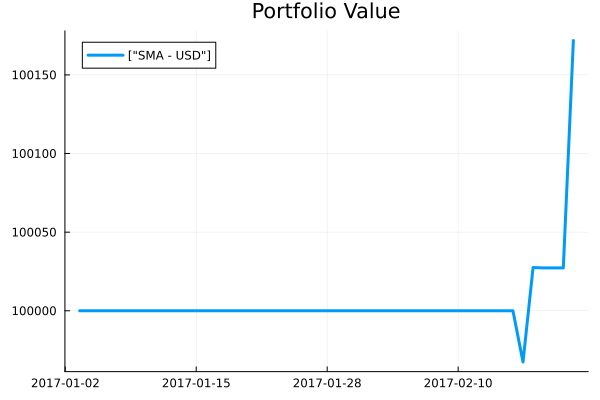

In [131]:

using AirBorne.Structures: summarizePerformance
using Plots: plot
results = summarizePerformance(data, context)
plot(results.date, results.dollarValue, title="Portfolio Value", label=["SMA - USD"], linewidth=3)

In [146]:
c2 =deepcopy(context)
# Maker return negative
c2.extra.returnHistory[!,"NMS/AAPL"]=-collect(1:size(c2.extra.returnHistory,1)) ./ size(c2.extra.returnHistory,1)
c2.extra.returnHistory[!,"NMS/GOOG"]=-collect(1:size(c2.extra.returnHistory,1)) ./ size(c2.extra.returnHistory,1)
c2.extra.returnHistory
# c2.extra.returnHistory[!,"NMS/AAPL"] = c2.extra.returnHistory[!,"NMS/AAPL"]*0-0.01*
c2.current_event= TimeEvent( c2.current_event.date + Day(1),"test")

TimeEvent(DateTime("2017-02-22T10:30:00"), "test")

In [147]:
my_expose_data(c2, data) 

Row,close,high,low,open,volume,date,unix,exchangeName,timezone,currency,symbol,assetID
,Float64,Float64,Float64,Float64,Int64,DateTime,Int64,String,String,String,String,String
1,34.2775,34.28,34.0275,34.1075,83347600,2017-02-22T10:30:00,1487773800,NMS,America/New_York,USD,AAPL,NMS/AAPL
2,41.538,41.6625,41.432,41.433,19658000,2017-02-22T10:30:00,1487773800,NMS,America/New_York,USD,GOOG,NMS/GOOG


true